<a href="https://colab.research.google.com/github/AUT-Student/BigData-HW1/blob/main/BigData_HW1_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><b>In the name of God</b></center>

<b>Course</b>: ‌Big Data
<br>
<b>Description:</b> HomeWork 1 | Question 3
<br>
<b>Developer</b>: Alireza Mazochi (400131075)

# Load and Prepare Dataset

In [15]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1-OCBGBtKoY_PadKHcXDyWxHQ2BS8Nulo'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('hw1.zip')

!unzip hw1.zip

Archive:  hw1.zip
replace hw1-files/q3/patches.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: hw1-files/q3/patches.csv  A

  inflating: hw1-files/q3/lsh.py     
  inflating: hw1-files/q1/dataset1.txt  
  inflating: hw1-files/q2/games_library.txt  


# LSH

In [33]:
# Authors: Jessica Su, Wanzi Zhou, Pratyaksh Sharma, Dylan Liu, Ansh Shukla
#Modified: Alex Porter
import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image

# Finds the L1 distance between two vectors
# u and v are 1-dimensional np.array objects
# Implemented by me!
def l1(u, v):
    distance = 0
    for i in range(len(u)):
      distance += np.abs(u[i]-v[i])
    return distance

# Loads the data into a np array, where each row corresponds to
# an image patch -- this step is sort of slow.
# Each row in the data is an image, and there are 400 columns.
def load_data(filename):
    return np.genfromtxt(filename, delimiter=',')

# Creates a hash function from a list of dimensions and thresholds.
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions 
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0, 
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold, 
                                   high = max_threshold + 1, 
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

# Hashes an individual vector (i.e. image).  This produces an array with L
# entries, where each entry is a string of k bits.
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

# Hashes the data in A, where each row is a datapoint, using the L
# functions in "functions."
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

# Retrieve all of the points that hash to one of the same buckets 
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

# Sets up the LSH.  You should try to call this function as few times as 
# possible, since it is expensive.
# A: The dataset in which each row is an image patch.
# Return the LSH functions and hashed data structure.
def lsh_setup(A, k = 24, L = 10):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)

# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)
    
    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors]

# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(base_filename + "-" + str(row_num) + ".png")

# Finds the nearest neighbors to a given vector, using linear search.
# Implemented by me!
def linear_search(A, query_index, num_neighbors):
    # All rows except query index are condidates! Remain of this function is similar to lsh_search
    candidate_row_nums = list(set(range(len(A))) - set([query_index]))
    
    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors]

# This function computes the error measure
# Implemented by me!
def error(A, hashed_A, functions, query_indexes, num_neighbors):
  error_sum = 0
  for query_index in query_indexes:
    lsh_ids = lsh_search(A, hashed_A, functions, query_index, num_neighbors)
    linear_ids = linear_search(A, query_index, num_neighbors)

    lsh_sum = 0
    linear_sum = 0
    for i in range(num_neighbors):
      lsh_sum += l1(A[lsh_ids[i]], A[query_index])
      linear_sum += l1(A[linear_ids[i]], A[query_index])
    
    error_sum += lsh_sum/linear_sum
  
  erorr_value = error_sum / len(query_indexes)
  return erorr_value

In [10]:
#### TESTS #####
class TestLSH(unittest.TestCase):
    def test_l1(self):
        u = np.array([1, 2, 3, 4])
        v = np.array([2, 3, 2, 3])
        self.assertEqual(l1(u, v), 4)

    def test_hash_data(self):
        f1 = lambda v: sum(v)
        f2 = lambda v: sum([x * x for x in v])
        A = np.array([[1, 2, 3], [4, 5, 6]])
        self.assertEqual(f1(A[0,:]), 6)
        self.assertEqual(f2(A[0,:]), 14)

        functions = [f1, f2]
        self.assertTrue(np.array_equal(hash_vector(functions, A[0, :]), np.array([6, 14])))
        self.assertTrue(np.array_equal(hash_data(functions, A), np.array([[6, 14], [15, 77]])))

unittest.main(argv=[''], verbosity=2, exit=False)

test_hash_data (__main__.TestLSH) ... ok
test_l1 (__main__.TestLSH) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.008s

OK


# Part B (Running Time Expriment)

In [29]:
import time

# Load Dataset
A = load_data(filename="/content/hw1-files/q3/patches.csv")

# LSH Setup
start_time = time.time()
functions, hashed_A = lsh_setup(A = A, k = 24, L = 10)
print(f"LSH Setup Time =  {time.time() - start_time} seconds")

# Query Index List
query_index_list = [100, 199, 300, 399, 500, 599, 700, 799, 900, 999]

# LSH Search
start_time = time.time()
for query_index in  query_index_list:
  lsh_best_row_nums = lsh_search(A, hashed_A, functions, query_index, num_neighbors = 3)
print(f"LSH Search Average Time =  {(time.time() - start_time)/len(query_index_list)} seconds")

# Linear Search
start_time = time.time()
for query_index in  query_index_list:
  linear_best_row_nums = linear_search(A, query_index, num_neighbors = 3)
print(f"Linear Search Average Time =  {(time.time() - start_time)/len(query_index_list)} seconds")

LSH Setup Time =  16.979037523269653 seconds
LSH Search Average Time =  1.323847723007202 seconds
Linear Search Average Time =  34.99098289012909 seconds


# Part C (Error Expriment)

In [34]:
# Load Dataset
A = load_data(filename="/content/hw1-files/q3/patches.csv")

# LSH Setup
functions, hashed_A = lsh_setup(A = A, k = 24, L = 10)

# Query Indexes
query_indexes = [100*j for j in range(1,11)]

# Calculate Error
error_value = error(A, hashed_A, functions, query_indexes, num_neighbors=3)
print(f"Error = {error_value}")

Error = 1.0107072993734474


# Part D (Parameter Effects Expriment)

In [ ]:
# Load Dataset
A = load_data(filename="/content/hw1-files/q3/patches.csv")

In [35]:
L_list = []
error_list = []

for L in [10, 12, 14, 16, 18, 20]:
  # LSH Setup
  functions, hashed_A = lsh_setup(A = A, k = 24, L = L)

  # Query Indexes
  query_indexes = [100*j for j in range(1,11)]

  # Calculate Error
  error_value = error(A, hashed_A, functions, query_indexes, num_neighbors=3)

  L_list.append(L)
  error_list.append(error_value)

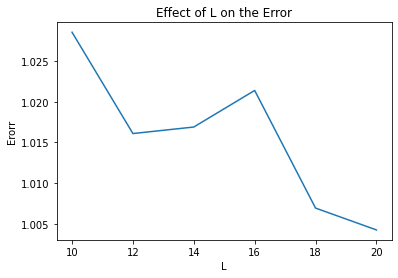

In [39]:
import matplotlib.pyplot as plt

plt.plot(L_list, error_list)
plt.xlabel("L")
plt.ylabel("Erorr")
plt.title("Effect of L on the Error")
plt.show()

In [40]:
k_list = []
error_list = []

for k in [16, 18, 20, 22, 24]:
  # LSH Setup
  functions, hashed_A = lsh_setup(A = A, k = k, L = 10)

  # Query Indexes
  query_indexes = [100*j for j in range(1,11)]

  # Calculate Error
  error_value = error(A, hashed_A, functions, query_indexes, num_neighbors=3)

  k_list.append(k)
  error_list.append(error_value)

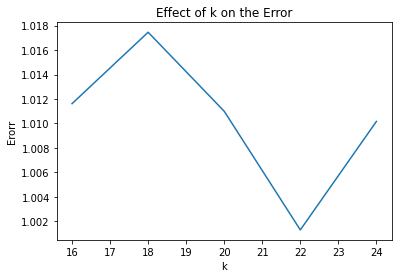

In [43]:
import matplotlib.pyplot as plt

plt.plot(k_list, error_list)
plt.xlabel("k")
plt.ylabel("Erorr")
plt.title("Effect of k on the Error")
plt.show()

# Part E (Qualitative Experiment)

In [46]:
# Load Dataset
A = load_data(filename="/content/hw1-files/q3/patches.csv")

# LSH Setup
functions, hashed_A = lsh_setup(A = A, k = 24, L = 10)

# Query Index
query_index = 100

# LSH Search
lsh_best_row_nums = lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10)

# Linear Search
linear_best_row_nums = linear_search(A, query_index, num_neighbors = 10)

# Save Plots
plot(A, lsh_best_row_nums, base_filename="LSH")
plot(A, linear_best_row_nums, base_filename="Linear")
plot(A, [100], base_filename="Query")

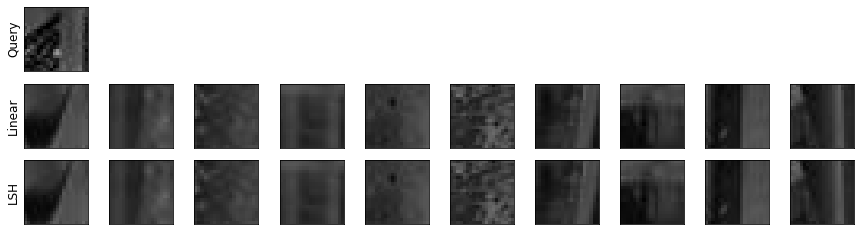

In [47]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots(3, 10)

img = mpimg.imread("Query-100.png")
ax[0][0].imshow(img)
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

for i in range(1, 10):
  fig.delaxes(ax[0][i])

for i in range(10):
  img = mpimg.imread(f"Linear-{linear_best_row_nums[i]}.png")
  ax[1][i].imshow(img)
  ax[1][i].set_xticks([])
  ax[1][i].set_yticks([])

  img = mpimg.imread(f"LSH-{lsh_best_row_nums[i]}.png")
  ax[2][i].imshow(img)
  ax[2][i].set_xticks([])
  ax[2][i].set_yticks([])


ax[0][0].set_ylabel("Query", rotation=90, size='large')
ax[1][0].set_ylabel("Linear", rotation=90, size='large')
ax[2][0].set_ylabel("LSH", rotation=90, size='large')

fig.set_size_inches(15, 4)

plt.show()